# Урок 6. Градиентный бустинг

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X.shape

(442, 10)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list,coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [8]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

In [11]:
%%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 1.95 s


In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2843.5528123598992
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 7232.022625664017


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [14]:
import matplotlib.pyplot as plt

In [15]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

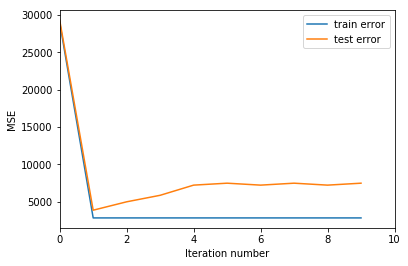

In [16]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [17]:
n_trees = 100
coefs = [1] * n_trees
max_depth = 5
eta = 1

In [18]:
%%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 3min 32s


In [19]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 1 на тренировочной выборке: 1869.640057274605
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 1 на тестовой выборке: 25538.087598230853


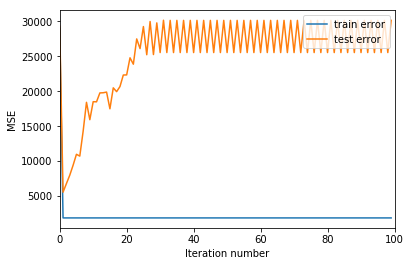

In [20]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [21]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [22]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 3.8002959403661474
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4103.932373498895


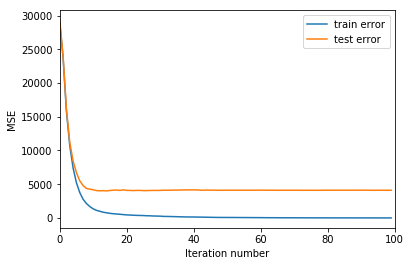

In [23]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [24]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 1406.36929324004
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 3916.928949899321


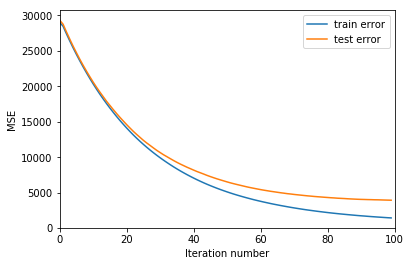

In [26]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [27]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [28]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 3.8002959403661474
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 4103.932373498895


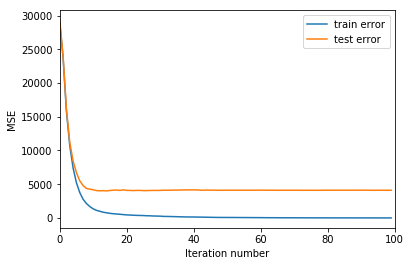

In [29]:
get_error_plot(n_trees, train_errors, test_errors)

## AdaBoost

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [31]:
X, y = load_breast_cancer(return_X_y=True)

Разделим выборку на обучающую и тестовую

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Реализуем функцию подсчета ошибки

In [33]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [34]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [35]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [36]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 97.183


In [37]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 93.706


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [38]:
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

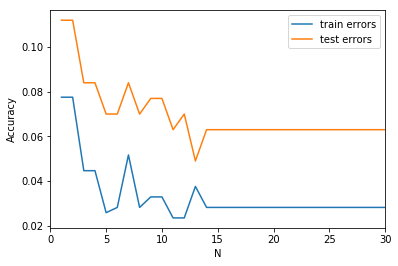

In [39]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

### Домашнее задание:  

#### 1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров. 

In [40]:
train_errors = []
test_errors = []
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

for n_trees in range(1, 21):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

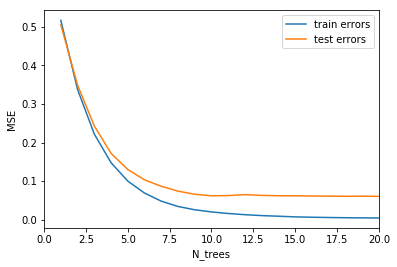

In [41]:
x = list(range(1, 21))

plt.xlim(0, 20)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N_trees')
plt.ylabel('MSE')
plt.legend(loc='upper right');

In [48]:
train_errors = []
test_errors = []
n_trees = 3
coefs = [1] * n_trees
eta = 0.1

for max_depth in range(1, 51):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

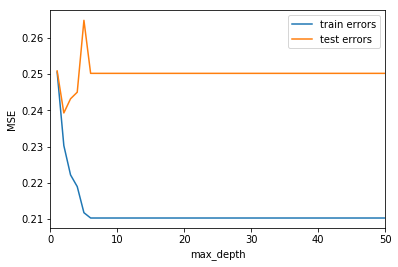

In [49]:
x = list(range(1, 51))

plt.xlim(0, 50)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

Как видно по графикам, ошибка уменьшается при увеличении количества деревьев и на тестовой выборке и на тренировочной. Причем ошибка на тестовой выборке не сильно отличается от ошибки на тренировочной, что говорит о хорошем обучении модели. 
При увеличении глубины деревьев можно видеть значительно снижение ошибки на тренировочной выборке, однако после примерно 7 ошибка более не изменяется. Но на тестовой выборке мы видим, что ошибка сначала идет на спад, а затем начинает расти, достигает своего максимума на глубине равной 7 и более не меняется. Такая разница ошибок на тренировочной и тестовой выборках свидетельствет о переобучении, значит данную модель необходимо ограничивать по глубине. Максимальная глубина должна быть не более 3.

#### 2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [50]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, rand_sample_size=0.5):
    
    trees = []
    
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            choice = list(range(X_train.shape[0]))
            train_indexes = np.random.choice(choice, size=int(0.5*len(choice)))
            
            pred = gb_predict(X_train[train_indexes], trees, coefs, eta)
            
            tree.fit(X_train[train_indexes], deriv(y_train[train_indexes], pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [51]:
n_trees = 20
coefs = [1] * n_trees
max_depth = 3
eta = 0.1

trees, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [52]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

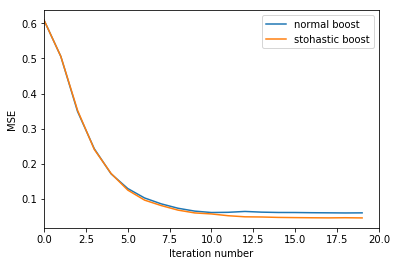

In [53]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
plt.plot(list(range(n_trees)), test_errors, label='normal boost')
plt.plot(list(range(n_trees)), test_errors_sgb, label='stohastic boost')
plt.legend(loc='upper right')
plt.show()